# Study about COVID-19 in Santa Catarina (Brazil)

Data source:

http://dados.sc.gov.br/dataset/covid-19-dados-anonimizados-de-casos-confirmados/resource/76d6dfe8-7fe9-45c1-95f4-cab971803d49


By Almir Bolduan - Rio do Sul - SC - Brazil

## 1. Installing

In [ ]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!pip install pydot
!apt-get install graphviz 
!pip install graphviz 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
!pip install h2o

     |████████████████████████████████| 177.0 MB 16 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=73e818248f7908dcff494e0f4a028021f04d3254b81a7c0e4cb91af9d06d834a
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


## 2. Importing and Initializing

In [ ]:
import pandas as pd
import time
import os.path
import sys
import subprocess
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Image
import h2o
from h2o import H2OFrame
from h2o.automl import H2OAutoML

In [ ]:
# Adjusting default graphic size and styles
plt.rcParams['figure.figsize'] = (12.0, 10.0)
np.set_printoptions(threshold=100)
sns.set()

In [ ]:
# initializing h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk6ztjqtp
  JVM stdout: /tmp/tmpk6ztjqtp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk6ztjqtp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_821esk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# https://towardsdatascience.com/reordering-pandas-dataframe-columns-thumbs-down-on-standard-solutions-1ff0bc2941d5
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

## 2. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/H2O.ai/data/boavista_covid_dados_abertos.csv', delimiter=';', usecols=['recuperados', 'sintomas', 'comorbidades', 'gestante', 'internacao', 'internacao_uti', 'sexo', 'municipio', 'obito', 'idade', 'raca', 'regional_saude'])
df.columns = df.columns.str.upper()
factorslist = []
df

,RECUPERADOS,SINTOMAS,COMORBIDADES,GESTANTE,INTERNACAO,INTERNACAO_UTI,SEXO,MUNICIPIO,OBITO,IDADE,RACA,REGIONAL_SAUDE
0,SIM,"TOSSE, DISPNEIA, DOR NO CORPO, DOR DE GARGANTA...",NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,FEMININO,JOINVILLE,NAO,63.0,NAO INFORMADO,NORDESTE
1,SIM,DOR DE GARGANTA,NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,FEMININO,BLUMENAU,NAO,32.0,NAO INFORMADO,MEDIO VALE DO ITAJAI
2,SIM,"TOSSE, DOR DE GARGANTA, FEBRE",NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,MASCULINO,XANXERE,NAO,59.0,NAO INFORMADO,XANXERE
3,SIM,NaN,NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,FEMININO,JOINVILLE,NAO,66.0,NAO INFORMADO,NORDESTE
4,SIM,NaN,NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,MASCULINO,TANGARA,NAO,35.0,NAO INFORMADO,ALTO VALE DO RIO DO PEIXE
...,...,...,...,...,...,...,...,...,...,...,...,...
238828,SIM,"TOSSE, CEFALEIA, CONGESTAO NASAL, DIARREIA, DI...",NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,FEMININO,PALHOCA,NAO,60.0,NAO INFORMADO,GRANDE FLORIANOPOLIS
238829,NAO,DIARREIA,NaN,NaN,INTERNADO,NAO INTERNADO UTI,MASCULINO,FLORIANOPOLIS,SIM,87.0,BRANCA,GRANDE FLORIANOPOLIS
238830,SIM,TOSSE,NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,FEMININO,SANGAO,NAO,41.0,NAO INFORMADO,LAGUNA
238831,SIM,"DIARREIA, DISPNEIA, DOR DE GARGANTA, FEBRE, MI...",NaN,NaN,NAO INTERNADO,NAO INTERNADO UTI,MASCULINO,LAURENTINO,NAO,11.0,NAO INFORMADO,ALTO VALE DO ITAJAI


In [ ]:
# Splitting symptoms column
df['SINTOMAS'] = df['SINTOMAS'].str.split(pat=', ').to_list()
sintomas = np.unique(np.concatenate(df['SINTOMAS'].dropna().values))

for sintoma in sintomas:
    sintoma_coluna = sintoma.replace(' ','_')
    df['SINTOMA_'+sintoma_coluna] = df.apply(lambda row: 1 if row['SINTOMAS'] is not np.nan and sintoma in row['SINTOMAS'] else 0, axis=1)
    factorslist.append('SINTOMA_'+sintoma_coluna)

del df['SINTOMAS']

In [ ]:
# Splitting comorbities column
df['COMORBIDADES'] = df['COMORBIDADES'].str.split(pat=', ').to_list()
comorbidades = np.unique(np.concatenate(df['COMORBIDADES'].dropna().values))

for comorbidade in comorbidades:
    comorbidade_coluna = comorbidade.replace(' ','_')
    df['COMORBIDADE_'+comorbidade_coluna] = df.apply(lambda row: 1 if row['COMORBIDADES'] is not np.nan and comorbidade in row['COMORBIDADES'] else 0, axis=1)
    factorslist.append('COMORBIDADE_'+comorbidade_coluna)

del df['COMORBIDADES']

In [ ]:
# Removing outliers
df['RACA'] = df['RACA'].replace(['IGNORADO','NAO INFORMADO'], np.nan)

df.loc[df['IDADE']>120,['IDADE']] = np.nan

It's a big class unbalance.


NAO    235835
SIM      2998
Name: OBITO, dtype: int64

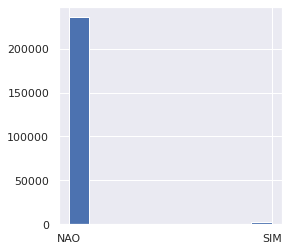

In [ ]:
print("It's a big class unbalance.")
df['OBITO'].hist(figsize=(4,4))
df['OBITO'].value_counts()

# 3. Analisys

## 3.1 Cases and Obits by Place

In [ ]:
df_casos_regional = df['REGIONAL_SAUDE'].value_counts().to_frame()
df_obitos_regional = df[df['OBITO'] == 'SIM']['REGIONAL_SAUDE'].value_counts().to_frame()

df_resumo_obitos = df_casos_regional.merge(df_obitos_regional, left_index=True, right_index=True)
df_resumo_obitos.columns = ['Casos Positivos', 'Óbitos']
df_resumo_obitos['Perc(%)'] = df_resumo_obitos.apply(lambda row: round(int(row['Óbitos'])/int(row['Casos Positivos'])*100,2), axis=1)
df_resumo_obitos = df_resumo_obitos.sort_values(by='Perc(%)', ascending=False)
df_resumo_obitos.loc['Total']= df_resumo_obitos.sum()
#df_resumo_obitos = df_resumo_obitos.append(df_resumo_obitos[['Casos Positivos','Óbitos']].sum().rename('Total'))
df_resumo_obitos.loc['Total']['Perc(%)'] = round(df_resumo_obitos.loc['Total']['Óbitos'] / df_resumo_obitos.loc['Total']['Casos Positivos'] * 100,2)
df_resumo_obitos

,Casos Positivos,Óbitos,Perc(%)
EXTREMO SUL CATARINENSE,5940.0,110.0,1.85
ALTO VALE DO RIO DO PEIXE,5014.0,92.0,1.83
SERRA CATARINENSE,6262.0,114.0,1.82
FOZ DO RIO ITAJAI,30165.0,481.0,1.59
XANXERE,6493.0,103.0,1.59
PLANALTO NORTE,3867.0,58.0,1.50
NORDESTE,35735.0,523.0,1.46
CARBONIFERA,15540.0,224.0,1.44
ALTO VALE DO ITAJAI,5404.0,72.0,1.33
LAGUNA,16978.0,212.0,1.25


## 3.2 Positive Cases x Obits per Age

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'histogram of feature: IDADE')

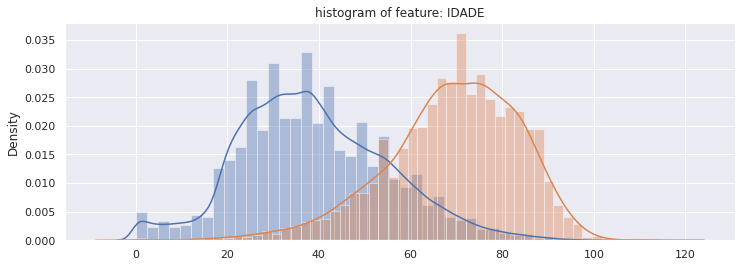

In [ ]:
plt.figure(figsize=(12,4))
ax = plt.subplot()
sns.distplot(df['IDADE'][df['OBITO'] == 'NAO'], bins=50)
sns.distplot(df['IDADE'][df['OBITO'] == 'SIM'], bins=50)
ax.set_xlabel('')
ax.set_title('histogram of feature: ' + str('IDADE'))

## 3.3 Reordering Columns

In [ ]:
del df['RECUPERADOS']
del df['REGIONAL_SAUDE']      
del df['INTERNACAO']      
del df['INTERNACAO_UTI']      
del df['GESTANTE']
del df['RACA']
del df['MUNICIPIO']


y = 'OBITO'

df = movecol(df, 
             cols_to_move=['OBITO'], 
             ref_col=df.columns[-1],
             place='After')

df_hex = H2OFrame(df)
df_hex[factorslist] = df_hex[factorslist].asfactor()
df_hex.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:238833
Cols:27




,SEXO,IDADE,SINTOMA_CANSACO,SINTOMA_CEFALEIA,SINTOMA_CONGESTAO_NASAL,SINTOMA_CORIZA,SINTOMA_DIARREIA,SINTOMA_DISPNEIA,SINTOMA_DOR_DE_GARGANTA,SINTOMA_DOR_NO_CORPO,SINTOMA_FEBRE,SINTOMA_MIALGIA,SINTOMA_TOSSE,COMORBIDADE_ASMA,COMORBIDADE_CANCER,COMORBIDADE_DIABETES,COMORBIDADE_DOENCA_CARDIOVASCULAR_CRONICA,COMORBIDADE_DOENCA_HEMATOLOGICA_CRONICA,COMORBIDADE_DOENCA_HEPATICA_CRONICA,COMORBIDADE_DOENCA_NEUROLOGICA_CRONICA,COMORBIDADE_DOENCA_PNEUMATICA_CRONICA,COMORBIDADE_DOENCA_RENAL_CRONICA,COMORBIDADE_HIPERTENSAO,COMORBIDADE_IMUNODEPRESSAO,COMORBIDADE_OBESIDADE,COMORBIDADE_SINDROME_DE_DOWN,OBITO
type,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum
mins,,0.0,,,,,,,,,,,,,,,,,,,,,,,,,
mean,,39.19896822605187,,,,,,,,,,,,,,,,,,,,,,,,,
maxs,,120.0,,,,,,,,,,,,,,,,,,,,,,,,,
sigma,,16.51279292274517,,,,,,,,,,,,,,,,,,,,,,,,,
zeros,,1080,,,,,,,,,,,,,,,,,,,,,,,,,
missing,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,FEMININO,63.0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
1,FEMININO,32.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
2,MASCULINO,59.0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO


# 4. Using H2O-3 AutoML to Predict Obits

In [ ]:
df_train, df_test = df_hex.split_frame(ratios=[.85], seed=1)

In [ ]:
x = df_train.columns
x.remove(y)
# x.remove('RECUPERADOS')
# x.remove('REGIONAL_SAUDE')

In [ ]:
aml = H2OAutoML(seed = 2, 
                max_runtime_secs=1*60*60,                             
                sort_metric="AUCPR",
                stopping_tolerance=0.01,
                stopping_rounds=3,              
                balance_classes=True, 
                nfolds = 5,  # Using 5 fold cross-validation
                )  
%time aml.train(x = x, y = y, training_frame = df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 48.7 s, sys: 3.18 s, total: 51.9 s
Wall time: 1h 1s
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_1_20220426_171223

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.006920831094779471
RMSE: 0.08319153259063973
LogLoss: 0.02468694521590301
Null degrees of freedom: 9994
Residual degrees of freedom: 9987
Null deviance: 1500.9016295154681
Residual deviance: 493.49203486590085
AIC: 509.49203486590085
AUC: 0.9884890789275685
AUCPR: 0.7210489802914707
Gini: 0.9769781578551371

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2768407423973756: 


,,NAO,SIM,Error,Rate
0,NAO,9796.0,56.0,0.0057,(56.0/9852.0)
1,SIM,43.0,100.0,0.3007,(43.0/143.0)
2,Total,9839.0,156.0,0.0099,(99.0/9995.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.276841,0.668896,114.0
1,max f2,0.152960,0.717791,179.0
2,max f0point5,0.692365,0.706052,27.0
3,max accuracy,0.510435,0.990595,57.0
4,max precision,0.999599,1.000000,0.0
5,max recall,0.000594,1.000000,387.0
6,max specificity,0.999599,1.000000,0.0
7,max absolute_mcc,0.262430,0.665074,118.0
8,max min_per_class_accuracy,0.022390,0.957166,295.0
9,max mean_per_class_accuracy,0.022390,0.957604,295.0



Gains/Lift Table: Avg response rate:  1.43 %, avg score:  1.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,0.423220,50.324476,50.324476,0.720000,0.746120,0.720000,0.746120,0.503497,0.503497,4932.447552,4932.447552,0.500654
1,2,0.020010,0.198228,24.463287,37.393881,0.350000,0.293253,0.535000,0.519686,0.244755,0.748252,2346.328671,3639.388112,0.738812
2,3,0.030015,0.085159,11.183217,28.656993,0.160000,0.137726,0.410000,0.392366,0.111888,0.860140,1018.321678,2765.699301,0.842174
3,4,0.040020,0.044540,6.290559,23.065385,0.090000,0.061311,0.330000,0.309602,0.062937,0.923077,529.055944,2206.538462,0.895874
4,5,0.050025,0.027415,2.096853,18.871678,0.030000,0.034251,0.270000,0.254532,0.020979,0.944056,109.685315,1787.167832,0.907008
5,6,0.100050,0.007372,0.559161,9.715420,0.008000,0.013991,0.139000,0.134262,0.027972,0.972028,-44.083916,871.541958,0.884635
6,7,0.151076,0.003118,0.274098,6.526629,0.003922,0.004743,0.093377,0.090517,0.013986,0.986014,-72.590155,552.662900,0.847057
7,8,0.200000,0.002156,0.142935,4.965035,0.002045,0.002594,0.071036,0.069009,0.006993,0.993007,-85.706523,396.503497,0.804517
8,9,0.300050,0.000751,0.000000,3.309471,0.000000,0.001455,0.047349,0.046484,0.000000,0.993007,-100.000000,230.947146,0.703015
9,10,0.403202,0.000341,0.067794,2.480149,0.000970,0.000504,0.035484,0.034721,0.006993,1.000000,-93.220649,148.014888,0.605461




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.006802926954145192
RMSE: 0.0824798578693319
LogLoss: 0.025517575801367418
Null degrees of freedom: 203044
Residual degrees of freedom: 203037
Null deviance: 27419.91199850633
Residual deviance: 10362.432357177291
AIC: 10378.432357177291
AUC: 0.9813633158864759
AUCPR: 0.6567378584083641
Gini: 0.9627266317729517

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2618046011979152: 


,,NAO,SIM,Error,Rate
0,NAO,199220.0,1272.0,0.0063,(1272.0/200492.0)
1,SIM,911.0,1642.0,0.3568,(911.0/2553.0)
2,Total,200131.0,2914.0,0.0108,(2183.0/203045.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.261805,0.600695,192.0
1,max f2,0.110149,0.671419,266.0
2,max f0point5,0.494146,0.646976,105.0
3,max accuracy,0.466455,0.990913,115.0
4,max precision,0.999385,1.000000,0.0
5,max recall,0.000032,1.000000,399.0
6,max specificity,0.999385,1.000000,0.0
7,max absolute_mcc,0.261805,0.596608,192.0
8,max min_per_class_accuracy,0.012756,0.937329,352.0
9,max mean_per_class_accuracy,0.013676,0.938577,350.0



Gains/Lift Table: Avg response rate:  1.26 %, avg score:  1.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.368769,51.924830,51.924830,0.652880,0.667333,0.652880,0.667333,0.519389,0.519389,5092.483023,5092.483023,0.515873
1,2,0.020005,0.165596,22.281469,37.103150,0.280158,0.253468,0.466519,0.460400,0.222875,0.742264,2128.146938,3610.314981,0.731456
2,3,0.030008,0.079200,10.103021,28.103107,0.127031,0.118070,0.353356,0.346290,0.101058,0.843322,910.302127,2710.310696,0.823670
3,4,0.040006,0.040319,4.544681,22.215676,0.057143,0.055740,0.279330,0.273679,0.045437,0.888758,354.468133,2121.567571,0.859560
4,5,0.050004,0.026152,1.880558,18.149854,0.023645,0.032329,0.228208,0.225424,0.018801,0.907560,88.055779,1714.985385,0.868476
5,6,0.100012,0.006631,0.900746,9.524875,0.011326,0.013226,0.119762,0.119320,0.045045,0.952605,-9.925437,852.487503,0.863449
6,7,0.150006,0.002837,0.297726,6.449663,0.003743,0.004308,0.081095,0.080989,0.014884,0.967489,-70.227435,544.966348,0.827893
7,8,0.200020,0.001845,0.203627,4.887885,0.002560,0.002311,0.061458,0.061316,0.010184,0.977673,-79.637321,388.788517,0.787556
8,9,0.300002,0.000901,0.125364,3.300665,0.001576,0.001332,0.041501,0.041325,0.012534,0.990208,-87.463566,230.066490,0.698994
9,10,0.400069,0.000466,0.039144,2.484883,0.000492,0.000646,0.031244,0.031150,0.003917,0.994125,-96.085642,148.488307,0.601620




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.989416,0.000408,0.988862,0.989199,0.989936,0.989616,0.989468
1,auc,0.981315,0.002954,0.980245,0.982487,0.977746,0.985659,0.980439
2,err,0.010584,0.000408,0.011138,0.010801,0.010064,0.010384,0.010532
3,err_count,429.800000,16.709278,454.000000,438.000000,411.000000,420.000000,426.000000
4,f0point5,0.584028,0.020355,0.549414,0.587422,0.595467,0.601704,0.586133
5,f1,0.604870,0.009714,0.590991,0.608229,0.601358,0.617486,0.606285
6,f2,0.627859,0.012238,0.639376,0.630564,0.607367,0.634119,0.627871
7,lift_top_group,52.094807,0.742256,51.291130,51.838500,51.795130,53.263540,52.285720
8,logloss,0.025517,0.000369,0.025402,0.025208,0.025982,0.025167,0.025826
9,max_per_class_error,0.355406,0.022969,0.323711,0.353612,0.388560,0.354286,0.356863



See the whole table with table.as_data_frame()


In [ ]:
lb = aml.leaderboard
lb.head(20)

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_2_AutoML_1_20220426_171223,0.656738,0.981363,0.0255176,0.18159,0.0824799,0.00680293
StackedEnsemble_BestOfFamily_3_AutoML_1_20220426_171223,0.656088,0.981575,0.0255242,0.188044,0.0825261,0.00681057
StackedEnsemble_BestOfFamily_1_AutoML_1_20220426_171223,0.652096,0.980086,0.0261412,0.18402,0.0829671,0.00688355
StackedEnsemble_AllModels_1_AutoML_1_20220426_171223,0.651221,0.980523,0.0259612,0.173216,0.0828775,0.00686868
StackedEnsemble_BestOfFamily_2_AutoML_1_20220426_171223,0.650213,0.980629,0.0259957,0.196016,0.0829407,0.00687916
GLM_1_AutoML_1_20220426_171223,0.647487,0.979656,0.0268816,0.192914,0.0839304,0.00704431
DeepLearning_1_AutoML_1_20220426_171223,0.643307,0.979096,0.0290309,0.19674,0.0858272,0.00736631
XGBoost_3_AutoML_1_20220426_171223,0.635734,0.979938,0.147573,0.191532,0.201698,0.0406822
XGBoost_grid_1_AutoML_1_20220426_171223_model_1,0.627555,0.958336,0.0399529,0.197367,0.086525,0.00748658
GBM_2_AutoML_1_20220426_171223,0.623775,0.979228,0.0280523,0.197885,0.0865363,0.00748853


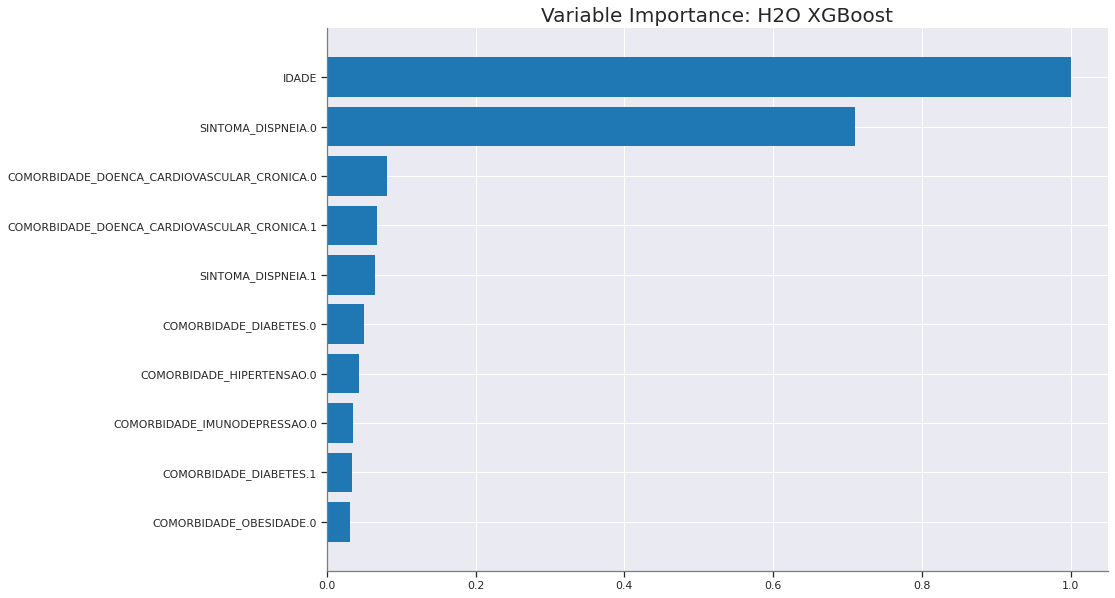

<Figure size 864x720 with 0 Axes>

In [ ]:
df = lb.as_data_frame()
for index, m in enumerate(df['model_id'].tolist()):
    if (m.find("XGBoost") != -1):
        leader_model = h2o.get_model(m)  # Get the best non-stacked model for further research.
        leader_model.varimp_plot()  
        break

In [ ]:
predict = leader_model.predict(df_test)
predict.as_data_frame()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,predict,NAO,SIM
0,NAO,0.901955,0.098045
1,NAO,0.979538,0.020462
2,NAO,0.915782,0.084218
3,NAO,0.773736,0.226264
4,NAO,0.993947,0.006053
...,...,...,...
35783,NAO,0.943597,0.056403
35784,NAO,0.980621,0.019379
35785,NAO,0.955357,0.044643
35786,NAO,0.989110,0.010890


In [ ]:
(predict['predict'] == df_test[y]).mean()

[0.9892980887448307]

In [ ]:
leader_model.model_performance(df_test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.04206714334350264
RMSE: 0.20510276288607776
LogLoss: 0.15224057461257826
Mean Per-Class Error: 0.20755014978412203
AUC: 0.9818673627662391
AUCPR: 0.6333269991366738
Gini: 0.9637347255324782

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9698909250172701: 


,,NAO,SIM,Error,Rate
0,NAO,35127.0,216.0,0.0061,(216.0/35343.0)
1,SIM,182.0,263.0,0.409,(182.0/445.0)
2,Total,35309.0,479.0,0.0111,(398.0/35788.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.969891,0.569264,14.0
1,max f2,0.894089,0.661818,44.0
2,max f0point5,0.991932,0.640107,3.0
3,max accuracy,0.991932,0.990863,3.0
4,max precision,0.999490,1.000000,0.0
5,max recall,0.015286,1.000000,362.0
6,max specificity,0.999490,1.000000,0.0
7,max absolute_mcc,0.969891,0.564031,14.0
8,max min_per_class_accuracy,0.465700,0.939326,152.0
9,max mean_per_class_accuracy,0.465700,0.940463,152.0



Gains/Lift Table: Avg response rate:  1.24 %, avg score:  9.60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.979855,50.095562,50.095562,0.622905,0.990994,0.622905,0.990994,0.501124,0.501124,4909.556211,4909.556211,0.497304
1,2,0.020007,0.941085,22.015090,36.055326,0.273743,0.962658,0.448324,0.976826,0.220225,0.721348,2101.509008,3505.532609,0.710172
2,3,0.030122,0.861610,10.885915,27.603260,0.135359,0.907148,0.343228,0.953428,0.110112,0.831461,988.591471,2660.326030,0.811428
3,4,0.040488,0.738124,3.901899,21.534796,0.048518,0.801336,0.267771,0.914486,0.040449,0.871910,290.189891,2053.479579,0.841890
4,5,0.050045,0.641266,3.056995,18.006371,0.038012,0.690001,0.223897,0.871620,0.029213,0.901124,205.699455,1700.637143,0.861795
5,6,0.100145,0.283177,1.076486,9.536705,0.013385,0.428227,0.118583,0.649800,0.053933,0.955056,7.648596,853.670496,0.865675
6,7,0.151280,0.143685,0.351574,6.432015,0.004372,0.204455,0.079978,0.499268,0.017978,0.973034,-64.842635,543.201521,0.832101
7,8,0.200682,0.093973,0.227439,4.904629,0.002828,0.113188,0.060986,0.404226,0.011236,0.984270,-77.256088,390.462861,0.793454
8,9,0.301079,0.050661,0.044766,3.284073,0.000557,0.069449,0.040835,0.292592,0.004494,0.988764,-95.523380,228.407310,0.696344
9,10,0.400917,0.022072,0.067525,2.483075,0.000840,0.033618,0.030875,0.228101,0.006742,0.995506,-93.247483,148.307465,0.602076


In [ ]:
perf = leader_model.model_performance(test_data=df_test)
perf


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.04206714334350264
RMSE: 0.20510276288607776
LogLoss: 0.15224057461257826
Mean Per-Class Error: 0.20755014978412203
AUC: 0.9818673627662391
AUCPR: 0.6333269991366738
Gini: 0.9637347255324782

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9698909250172701: 


,,NAO,SIM,Error,Rate
0,NAO,35127.0,216.0,0.0061,(216.0/35343.0)
1,SIM,182.0,263.0,0.409,(182.0/445.0)
2,Total,35309.0,479.0,0.0111,(398.0/35788.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.969891,0.569264,14.0
1,max f2,0.894089,0.661818,44.0
2,max f0point5,0.991932,0.640107,3.0
3,max accuracy,0.991932,0.990863,3.0
4,max precision,0.999490,1.000000,0.0
5,max recall,0.015286,1.000000,362.0
6,max specificity,0.999490,1.000000,0.0
7,max absolute_mcc,0.969891,0.564031,14.0
8,max min_per_class_accuracy,0.465700,0.939326,152.0
9,max mean_per_class_accuracy,0.465700,0.940463,152.0



Gains/Lift Table: Avg response rate:  1.24 %, avg score:  9.60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.979855,50.095562,50.095562,0.622905,0.990994,0.622905,0.990994,0.501124,0.501124,4909.556211,4909.556211,0.497304
1,2,0.020007,0.941085,22.015090,36.055326,0.273743,0.962658,0.448324,0.976826,0.220225,0.721348,2101.509008,3505.532609,0.710172
2,3,0.030122,0.861610,10.885915,27.603260,0.135359,0.907148,0.343228,0.953428,0.110112,0.831461,988.591471,2660.326030,0.811428
3,4,0.040488,0.738124,3.901899,21.534796,0.048518,0.801336,0.267771,0.914486,0.040449,0.871910,290.189891,2053.479579,0.841890
4,5,0.050045,0.641266,3.056995,18.006371,0.038012,0.690001,0.223897,0.871620,0.029213,0.901124,205.699455,1700.637143,0.861795
5,6,0.100145,0.283177,1.076486,9.536705,0.013385,0.428227,0.118583,0.649800,0.053933,0.955056,7.648596,853.670496,0.865675
6,7,0.151280,0.143685,0.351574,6.432015,0.004372,0.204455,0.079978,0.499268,0.017978,0.973034,-64.842635,543.201521,0.832101
7,8,0.200682,0.093973,0.227439,4.904629,0.002828,0.113188,0.060986,0.404226,0.011236,0.984270,-77.256088,390.462861,0.793454
8,9,0.301079,0.050661,0.044766,3.284073,0.000557,0.069449,0.040835,0.292592,0.004494,0.988764,-95.523380,228.407310,0.696344
9,10,0.400917,0.022072,0.067525,2.483075,0.000840,0.033618,0.030875,0.228101,0.006742,0.995506,-93.247483,148.307465,0.602076


# 5. Model Explainability

## 5.1. Correlation Matrix

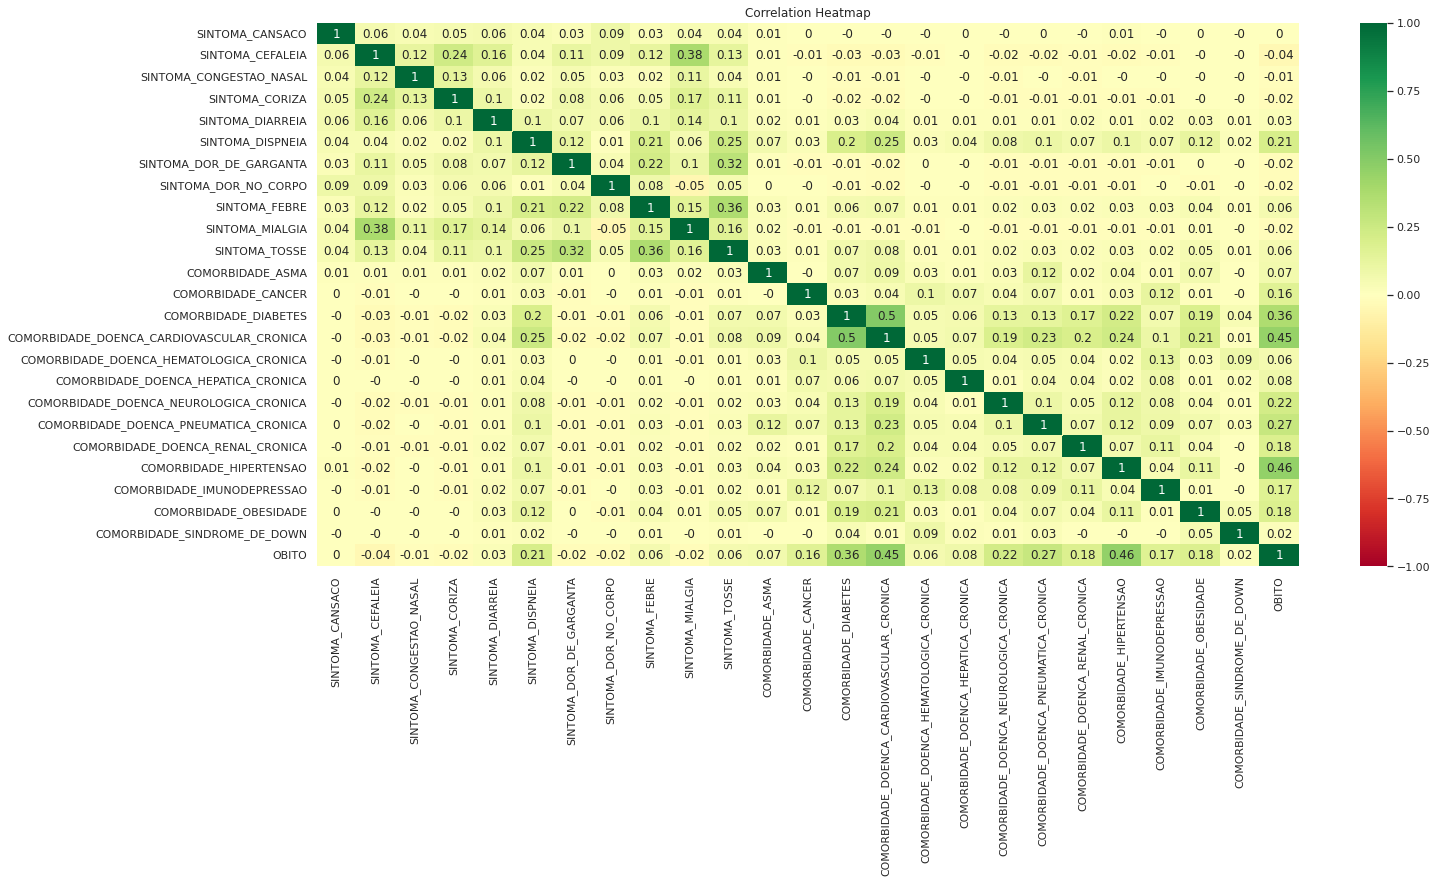

In [ ]:
import seaborn as sns

plt.figure(figsize=(22,10))

#converting to data frame - couldn't easily figure out how to do it with h2o
colunas_correlacao = df_train.drop(['IDADE','SEXO']).columns
corr_matrix = df_train[colunas_correlacao].cor()
corr = corr_matrix.as_data_frame().round(decimals=2)
corr.index = corr_matrix.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=12)
plt.show()

## 5.2. Explain the Leader Model

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_3_AutoML_1_20220426_171223


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9721524020036062: 


,,NAO,SIM,Error,Rate
0,NAO,199541.0,951.0,0.0047,(951.0/200492.0)
1,SIM,1025.0,1528.0,0.4015,(1025.0/2553.0)
2,Total,200566.0,2479.0,0.0097,(1976.0/203045.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

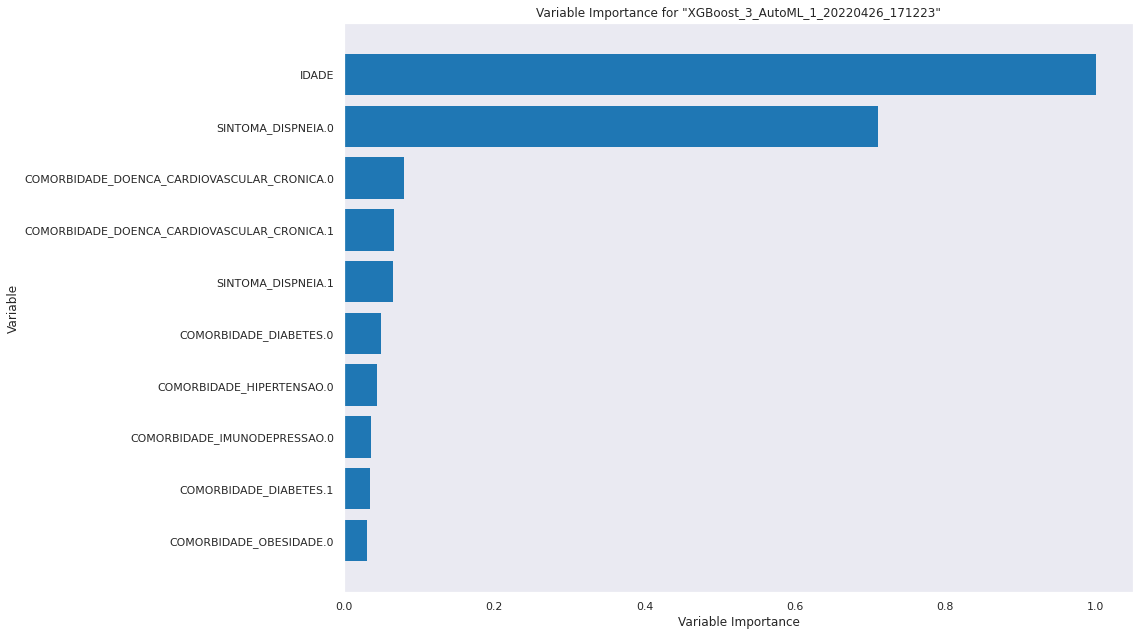

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

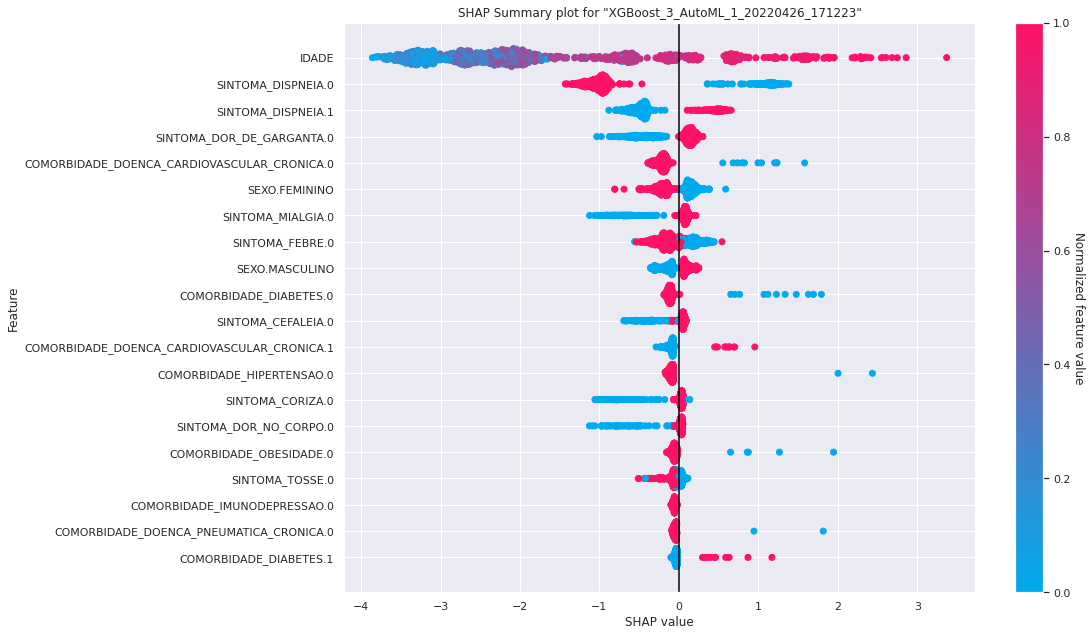

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

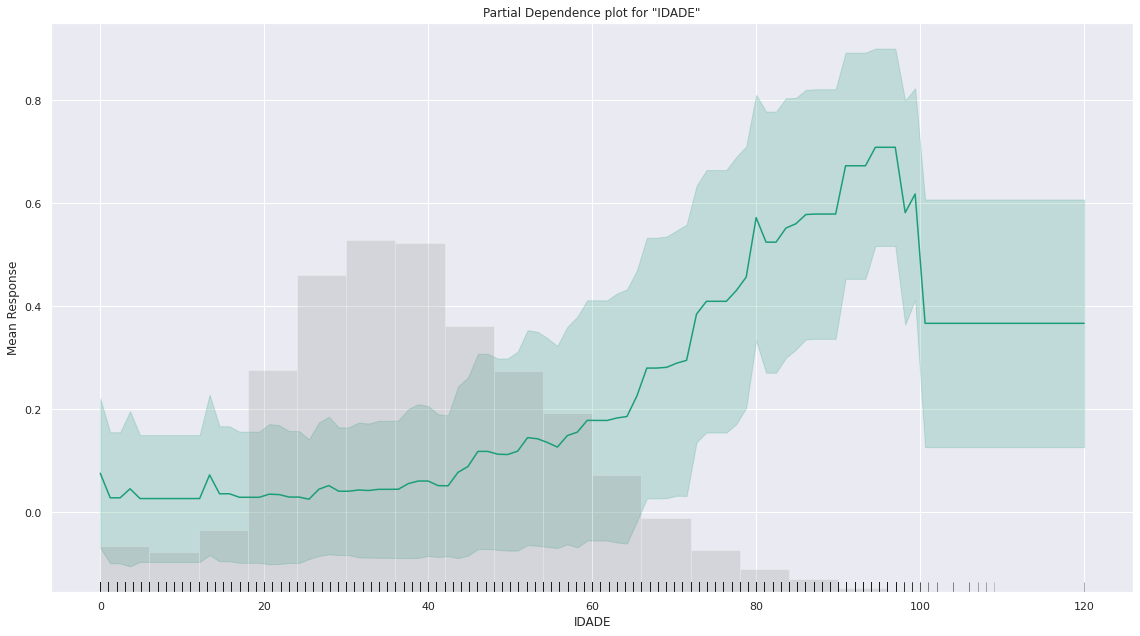

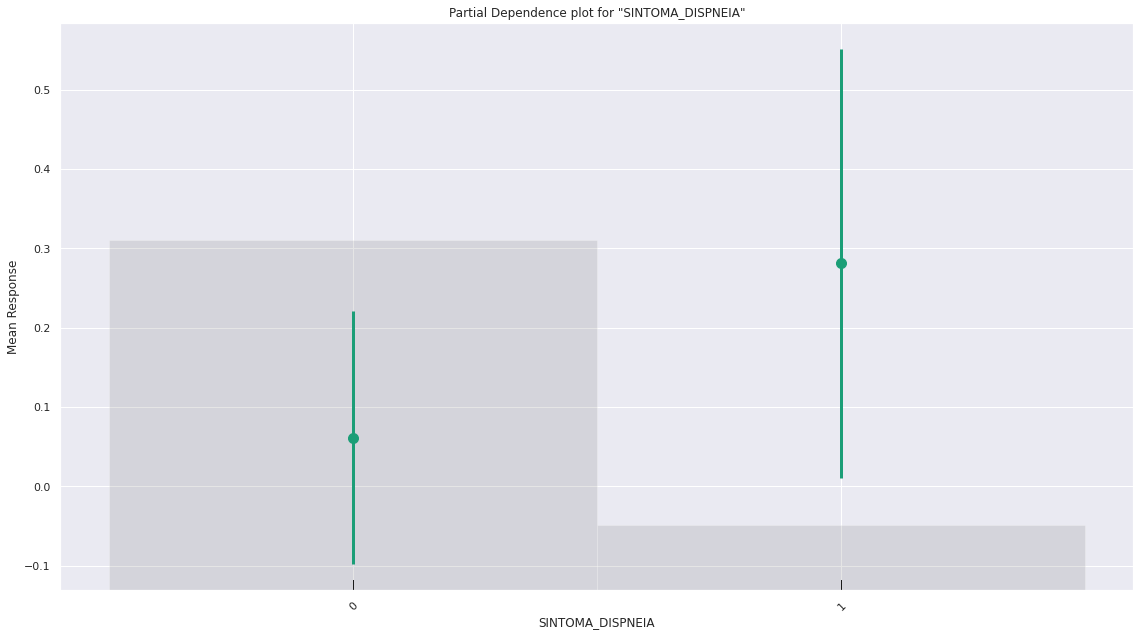

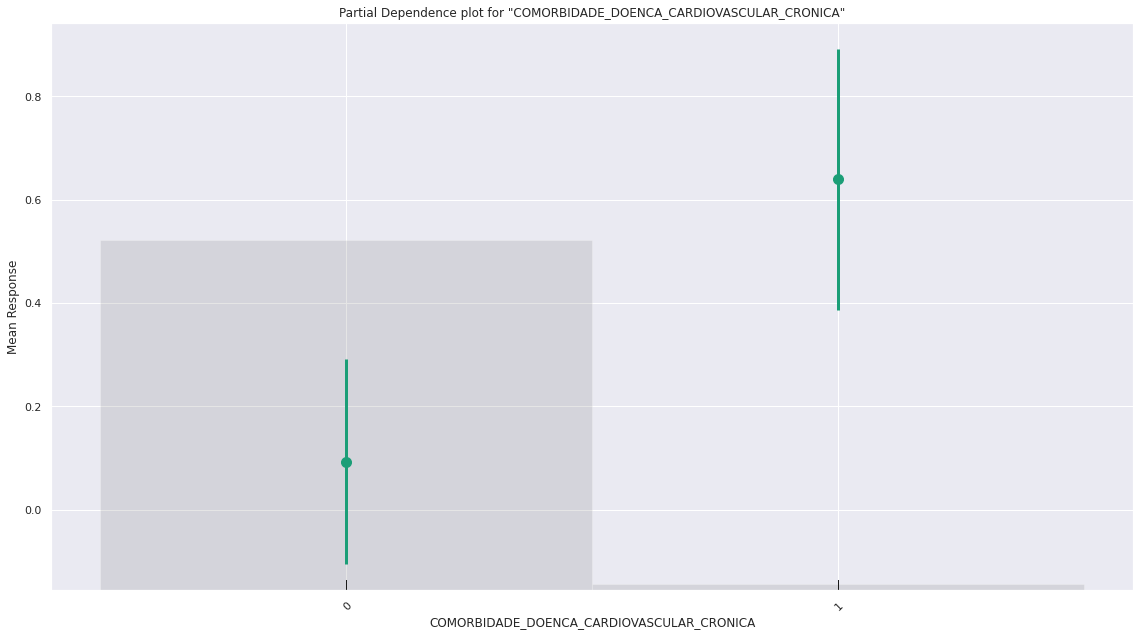

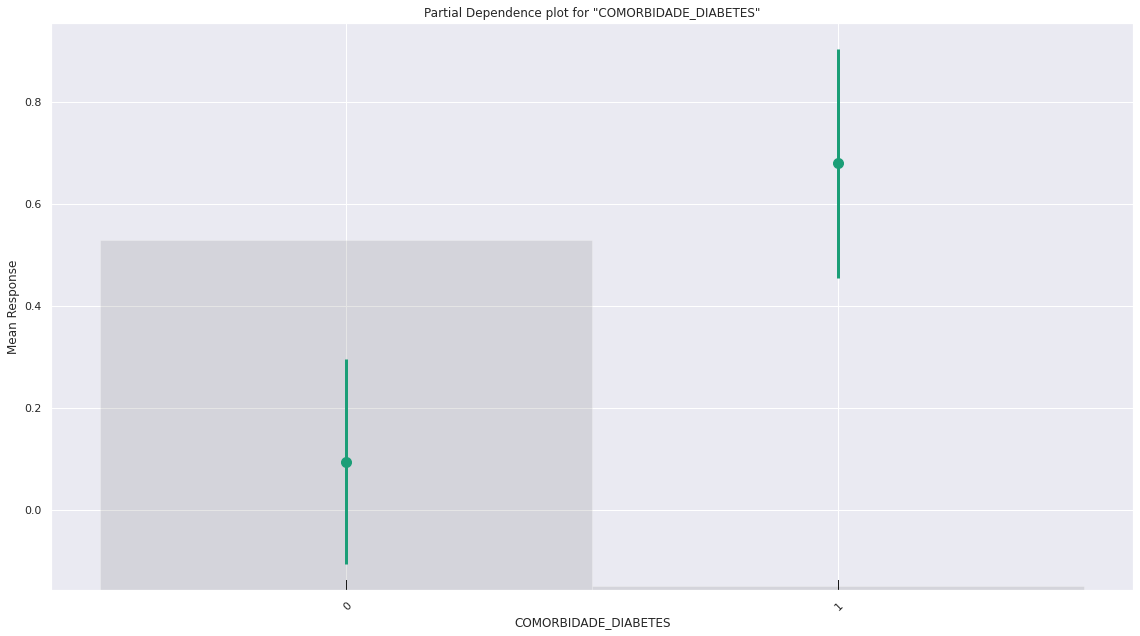

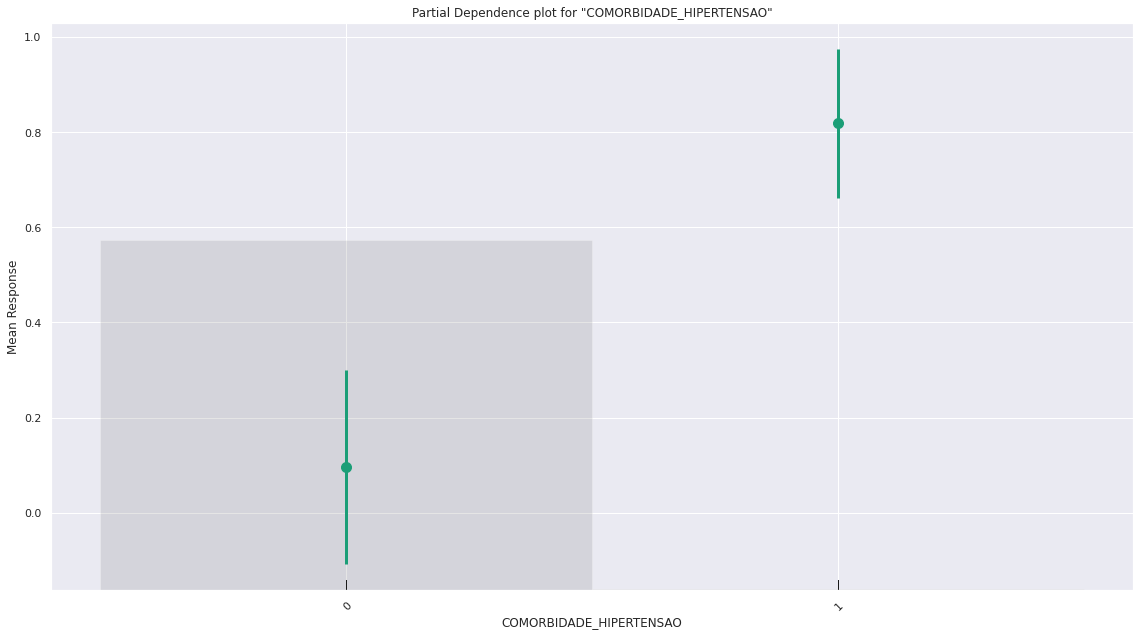

In [ ]:
leader_model.explain(df_train, include_explanations='ALL');

## 5.3. Explain a random row

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

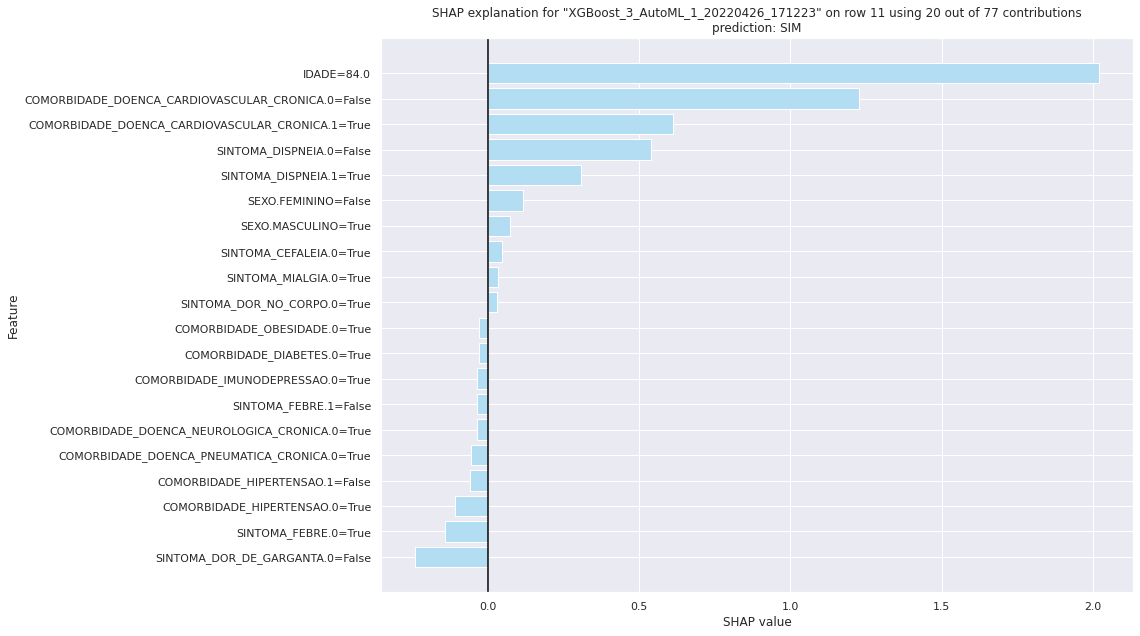

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

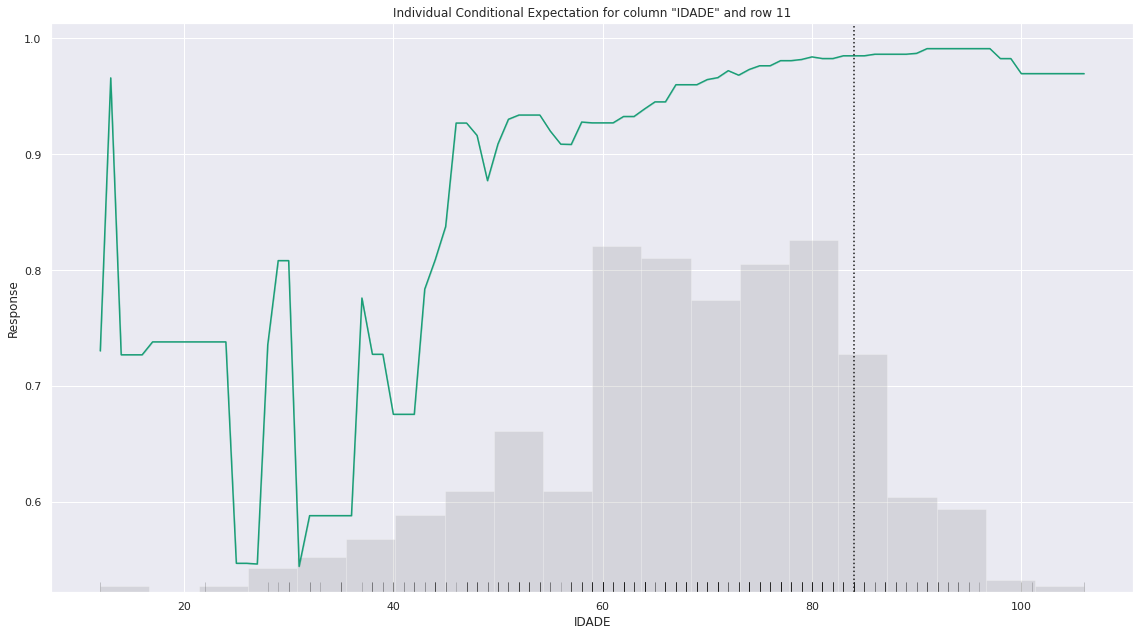

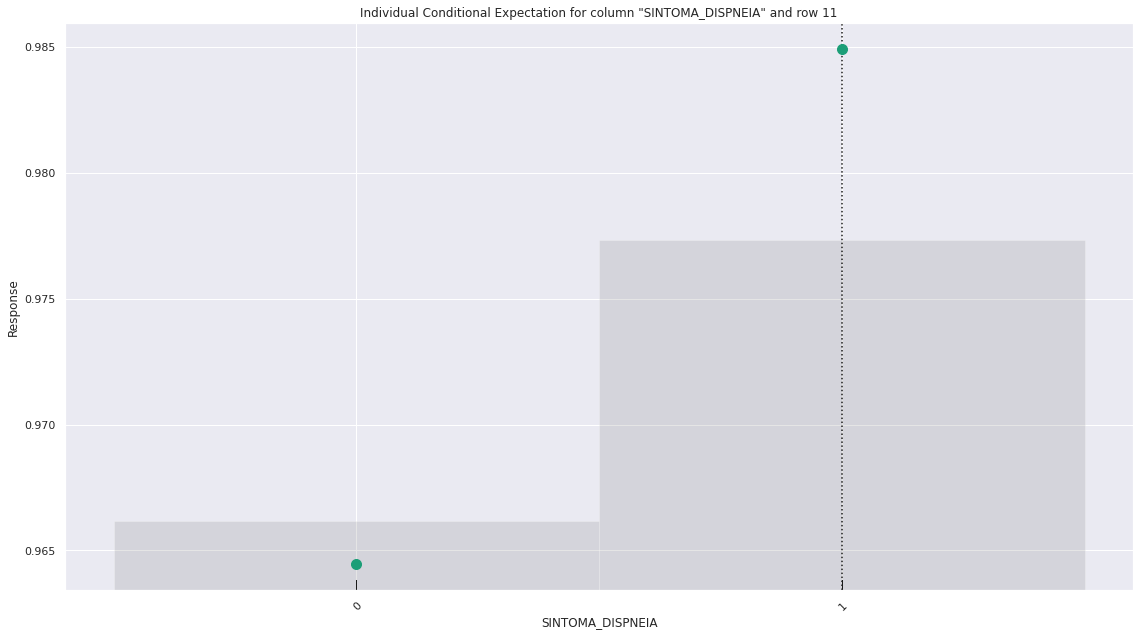

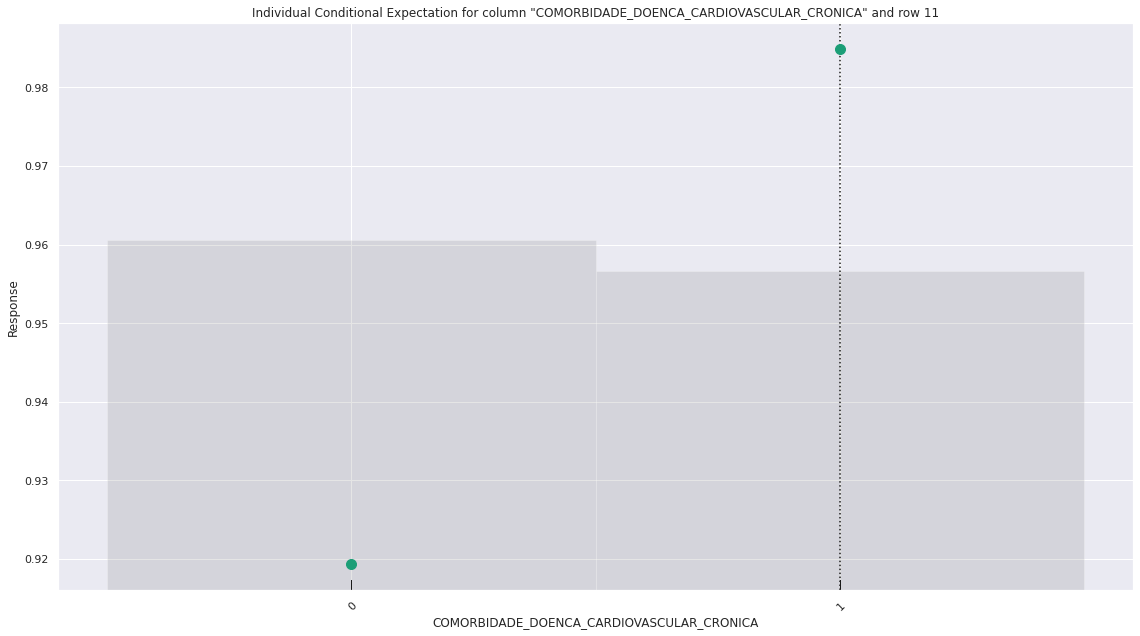

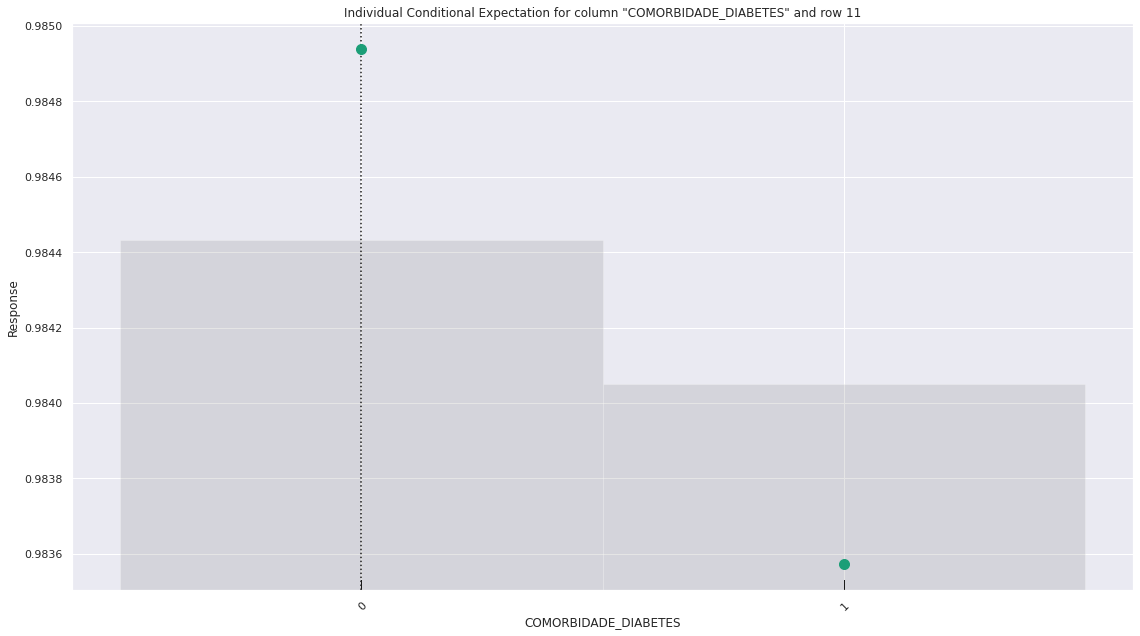

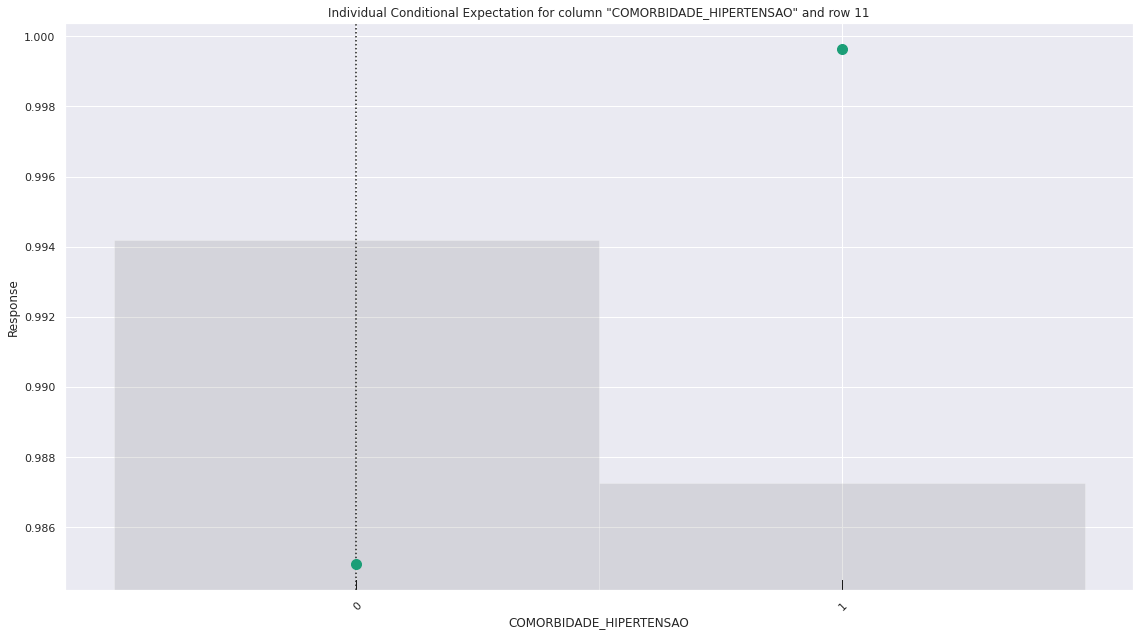

In [ ]:
leader_model.explain_row(df_test[df_test['OBITO'] == 'SIM'], row_index=11);

## 5.4. Creating a Surrogate (simplified) Model and Tree

In [ ]:
surrogate_dt_data = leader_model.predict(df_train).cbind(df_train)
surrogate_dt_data.head()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict,NAO,SIM,SEXO,IDADE,SINTOMA_CANSACO,SINTOMA_CEFALEIA,SINTOMA_CONGESTAO_NASAL,SINTOMA_CORIZA,SINTOMA_DIARREIA,SINTOMA_DISPNEIA,SINTOMA_DOR_DE_GARGANTA,SINTOMA_DOR_NO_CORPO,SINTOMA_FEBRE,SINTOMA_MIALGIA,SINTOMA_TOSSE,COMORBIDADE_ASMA,COMORBIDADE_CANCER,COMORBIDADE_DIABETES,COMORBIDADE_DOENCA_CARDIOVASCULAR_CRONICA,COMORBIDADE_DOENCA_HEMATOLOGICA_CRONICA,COMORBIDADE_DOENCA_HEPATICA_CRONICA,COMORBIDADE_DOENCA_NEUROLOGICA_CRONICA,COMORBIDADE_DOENCA_PNEUMATICA_CRONICA,COMORBIDADE_DOENCA_RENAL_CRONICA,COMORBIDADE_HIPERTENSAO,COMORBIDADE_IMUNODEPRESSAO,COMORBIDADE_OBESIDADE,COMORBIDADE_SINDROME_DE_DOWN,OBITO
NAO,0.417898,0.582102,FEMININO,63,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.998456,0.001544,FEMININO,32,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.863979,0.136021,MASCULINO,59,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.856315,0.143685,FEMININO,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.99273,0.00726993,MASCULINO,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.994567,0.00543329,MASCULINO,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.979666,0.020334,MASCULINO,38,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.985768,0.0142325,MASCULINO,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.995461,0.00453873,MASCULINO,37,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO
NAO,0.994971,0.00502953,FEMININO,66,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NAO


In [ ]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

dt = H2ORandomForestEstimator(#model_id="surrogate.hex",
                              ntrees=1, max_depth=4,
                              sample_rate=1,
                              #categorical_encoding="one_hot_explicit",
                              mtries=-2,
                              min_rows=30 # use min rows to prevent small leaf nodes and fitting noise
                             )
dt.train(y="SIM", training_frame=surrogate_dt_data, x=x)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1650992992376_1718


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,258.0,4.0,4.0,4.0,16.0,16.0,16.0




ModelMetricsRegression: drf
** Reported on train data. **

MSE: NaN
RMSE: NaN
MAE: NaN
RMSLE: NaN
Mean Residual Deviance: NaN

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-04-26 18:35:52,0.003 sec,0.0,NaN,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,IDADE,3622.974854,1.000000,0.507763
1,SINTOMA_DISPNEIA,3001.978271,0.828595,0.420730
2,COMORBIDADE_DOENCA_CARDIOVASCULAR_CRONICA,438.385620,0.121002,0.061440
3,COMORBIDADE_OBESIDADE,69.446854,0.019168,0.009733
4,SINTOMA_CEFALEIA,2.379597,0.000657,0.000334
5,SEXO,0.000000,0.000000,0.000000
6,SINTOMA_CANSACO,0.000000,0.000000,0.000000
7,SINTOMA_CONGESTAO_NASAL,0.000000,0.000000,0.000000
8,SINTOMA_CORIZA,0.000000,0.000000,0.000000
9,SINTOMA_DIARREIA,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


In [ ]:
import os
import subprocess
from IPython.display import Image

def generateTreeImage(model, tree_number, custom_title=None, detail=False):
    # Download MOJO
    mojo_path = model.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    # -d = decimal places
    gv_params = ["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", str(tree_number), "-i", mojo_path , "-o", gv_file_path, "-d", "4"]
    if custom_title is not None:
        gv_params.append('--title')
        gv_params.append(f'"{custom_title}"')
    if detail:
        gv_params.append('--detail')
        gv_params.append('--fontsize')
        gv_params.append("30")
    gv_call = " ".join(gv_params)
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o decision_tree.png"], shell=False)
    result = subprocess.call(["dot", "-Tpdf", gv_file_path, "-o decision_tree.pdf"], shell=False)
    result = subprocess.call(["ls","decision_tree.png"], shell = False)
    
    return Image(" decision_tree.png")

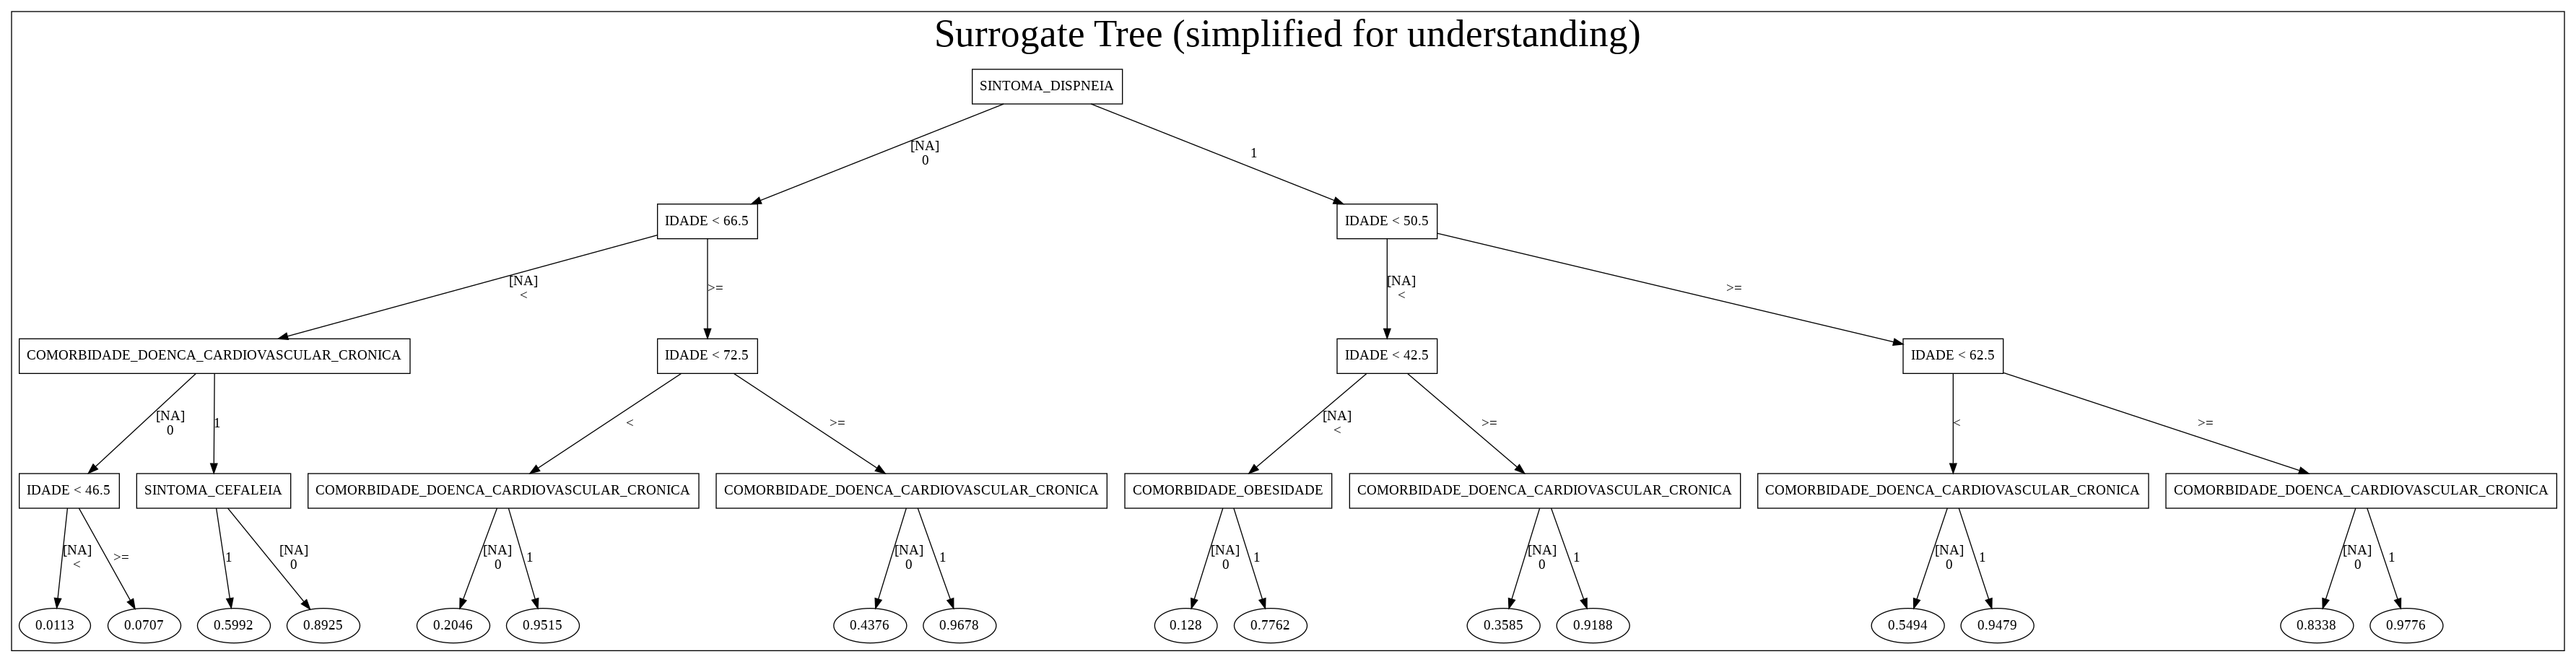

In [ ]:
generateTreeImage(dt, 0, "Surrogate Tree (simplified for understanding)", detail=False)

## 5.5. Residual Tree from Surrogate Model

In [ ]:
surrogate_dt_data["error"] = surrogate_dt_data["predict"] != surrogate_dt_data["OBITO"]

residual_dt = H2ORandomForestEstimator(model_id="residual_surrogate.hex",
                                       ntrees=1, max_depth=4,
                                       sample_rate=1,
                                       #categorical_encoding="one_hot_explicit",
                                       mtries=-2,
                                       min_rows=20 # use min rows to prevent small leaf nodes and fitting noise
                                      )
residual_dt.train(y="error", training_frame=surrogate_dt_data, x=x)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  residual_surrogate.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,233.0,4.0,4.0,4.0,14.0,14.0,14.0




ModelMetricsRegression: drf
** Reported on train data. **

MSE: NaN
RMSE: NaN
MAE: NaN
RMSLE: NaN
Mean Residual Deviance: NaN

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-04-26 18:35:53,0.003 sec,0.0,NaN,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,COMORBIDADE_DOENCA_CARDIOVASCULAR_CRONICA,286.449158,1.000000,0.607723
1,COMORBIDADE_DIABETES,63.712414,0.222421,0.135171
2,COMORBIDADE_HIPERTENSAO,42.131298,0.147081,0.089385
3,IDADE,38.046951,0.132823,0.080719
4,COMORBIDADE_DOENCA_PNEUMATICA_CRONICA,18.267834,0.063773,0.038757
5,COMORBIDADE_DOENCA_NEUROLOGICA_CRONICA,11.336089,0.039575,0.024050
6,COMORBIDADE_OBESIDADE,8.303747,0.028989,0.017617
7,SINTOMA_DISPNEIA,3.100816,0.010825,0.006579
8,SEXO,0.000000,0.000000,0.000000
9,SINTOMA_CANSACO,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


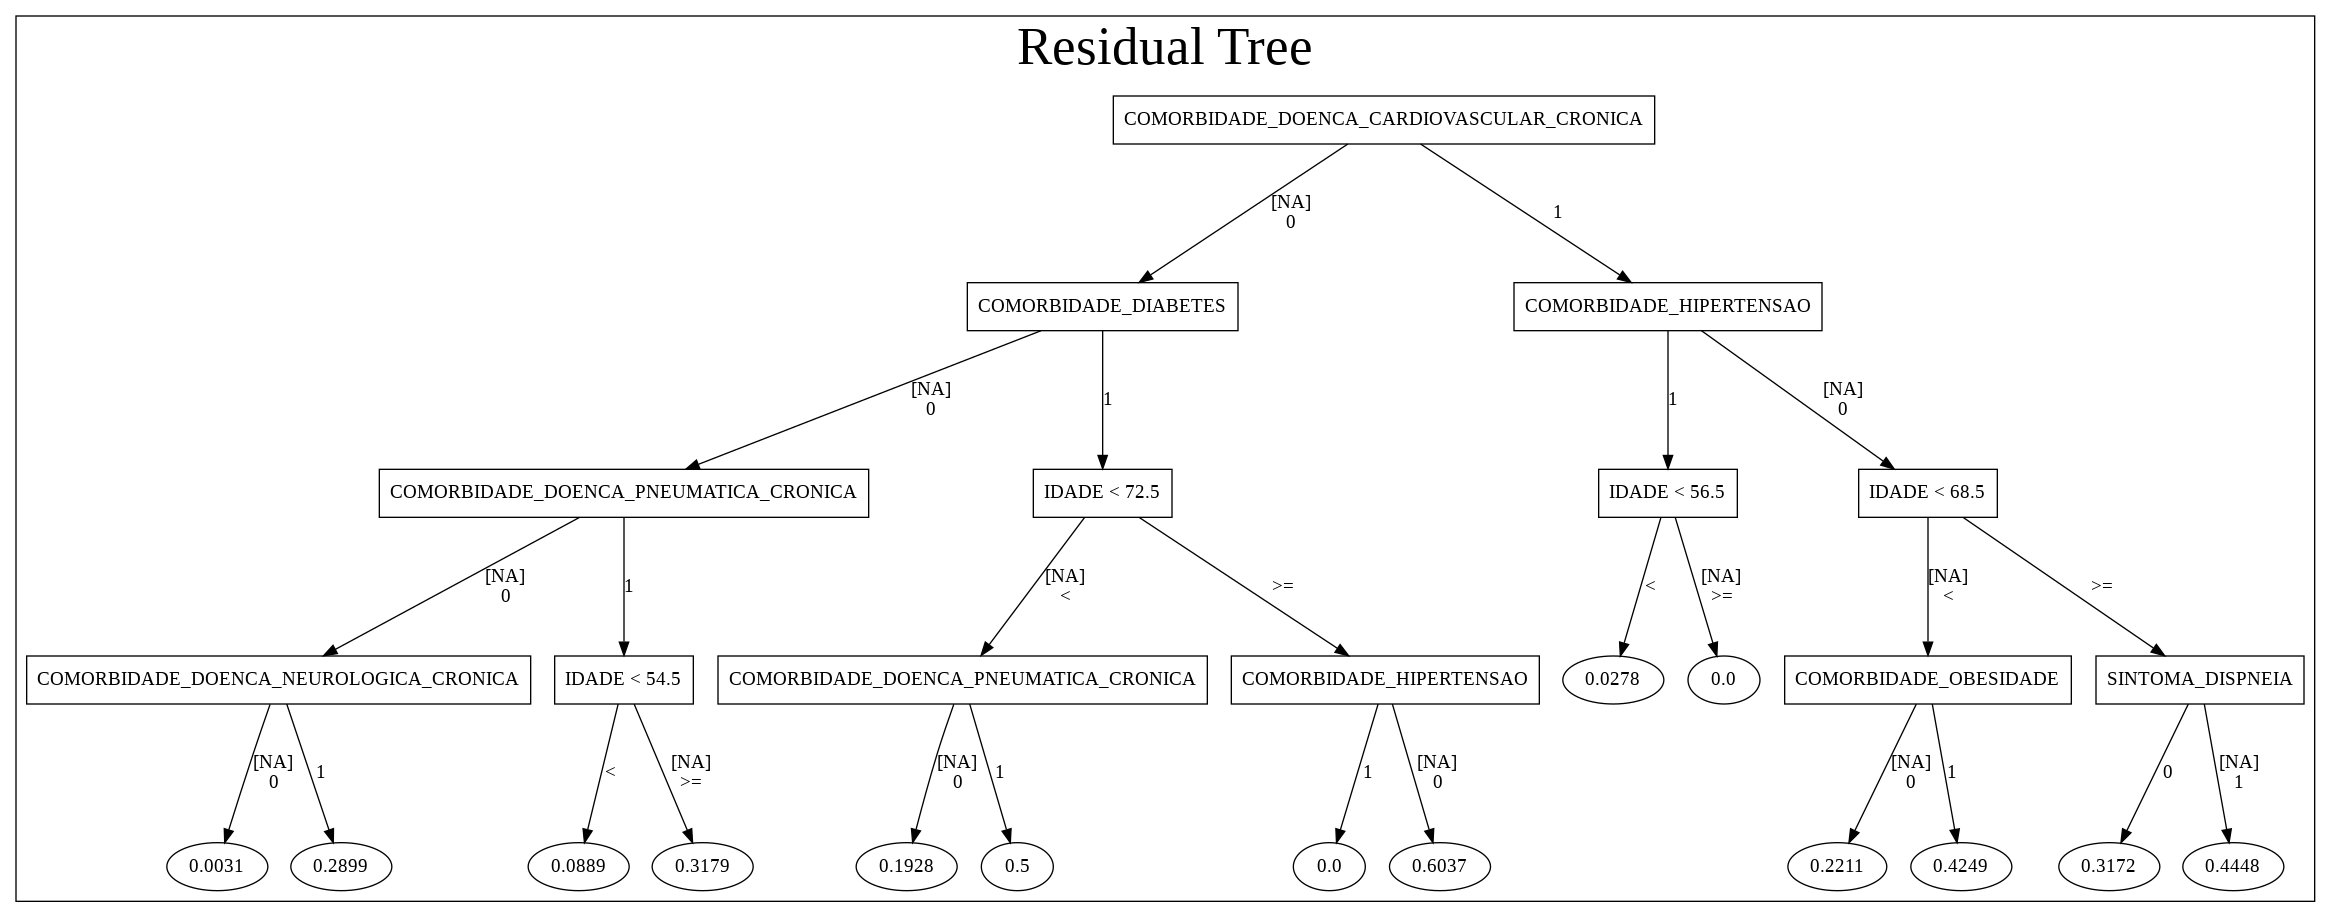

In [ ]:
generateTreeImage(residual_dt, 0, "Residual Tree", detail=False)